In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input size is 28x28 (MNIST images)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output size is 10 (digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
# Define the training parameters
learning_rate = 0.001
batch_size = 64
epochs = 10

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [4]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [5]:
train_losses = []
val_losses = []

In [6]:
# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(trainloader))

    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(testloader))
    net.train()



    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

print("Training Finished")

Epoch 1, Loss: 2.218417091410297
Epoch 2, Loss: 1.9445588915332803
Epoch 3, Loss: 1.470588303324002
Epoch 4, Loss: 1.0384014906532475
Epoch 5, Loss: 0.7939249085846232
Epoch 6, Loss: 0.6588939552241043
Epoch 7, Loss: 0.5770386225823909
Epoch 8, Loss: 0.522574092914809
Epoch 9, Loss: 0.4839214423953343
Epoch 10, Loss: 0.45453964076888587
Training Finished


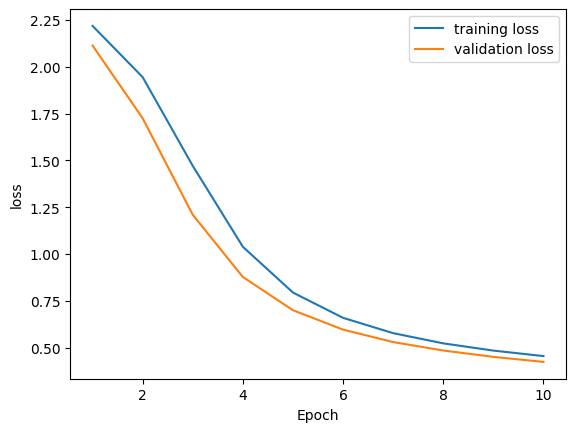

In [7]:
torch.save(net.state_dict(), "mnist_net.pth")

plt.plot(range(1, epochs+1), train_losses, label="training loss")
plt.plot(range(1, epochs+1), val_losses, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
net = Net()
net.load_state_dict(torch.load("mnist_net.pth"))
net.eval()

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 88.60%


In [10]:
#conf mat

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

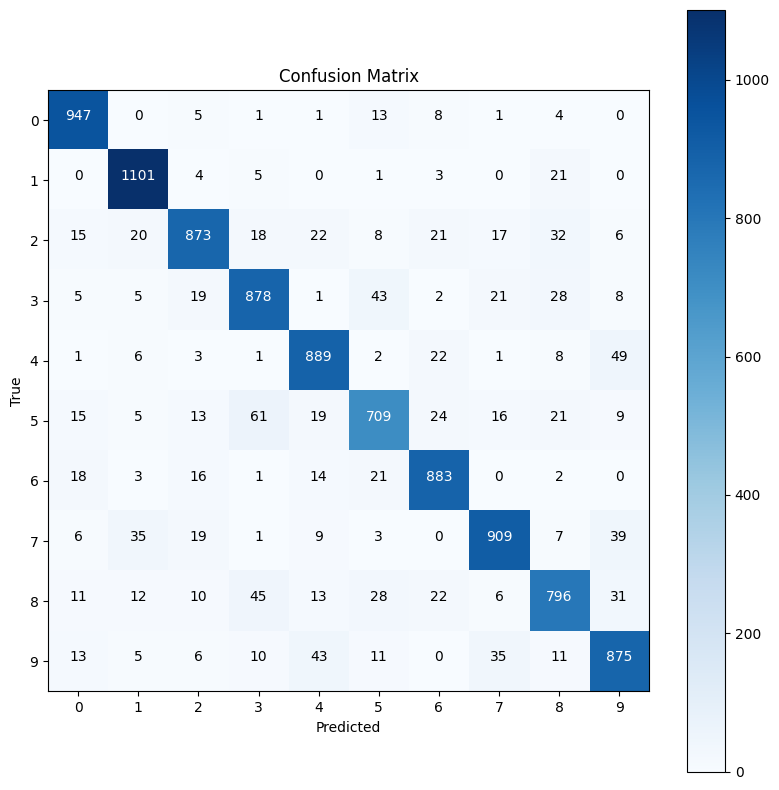

In [12]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8,8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color = 'white' if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

class_names = [str(i) for i in range(10)]

plot_confusion_matrix(conf_matrix, class_names)

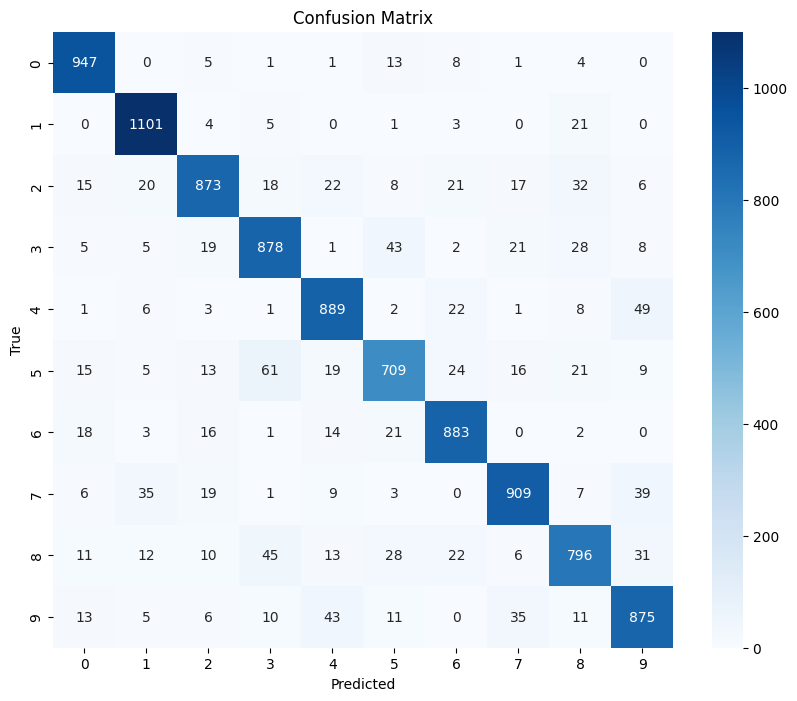

In [14]:
def seaborn_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

seaborn_confusion_matrix(conf_matrix, class_names)